Benchmark Filesystems
---------------------

In [1]:
# These are not portable definitions.  If you're running it, you're going
# to have to adjust these.

import os
import subprocess
from copy import deepcopy
from dataclasses import dataclass
from pathlib import Path
from typing import Any

from pandas import DataFrame

homedir = Path(os.getenv("HOME"))
user = os.getenv("USER")

# fio binary (locally-built)
fioexec = homedir / "work" / "fio" / "fio"
# Where results and job files live
resultsdir = homedir / "work" / "fio-compare" / "results"
fiodefdir = homedir / "work" / "fio-compare" / "config"

# We (conventionally) have "home", "project", and "scratch" in each of these.
# NFSv3 and NFSv4 refer to the same device presented differently, so we're
# going to make the test dir different for each.  Filestore is its own thing.
nfsv4root = Path("/")
nfsv3root = Path("/nfsv3")
filestoreroot = Path("/filestore")

nfsmap = {
    "netapp_nfsv4": nfsv4root / "scratch" / user / "fsbench" / "nfsv4",
    "netapp_nfsv3": nfsv3root / "scratch" / user / "fsbench" / "nfsv3",
    "filestore_nfsv3": filestoreroot / "scratch" / user / "fsbench" / "filestore"
}

# Create our results, config, and runtime directories
dirs = list(nfsmap.values())
dirs.extend([resultsdir, fiodefdir])
for d in dirs:
    d.mkdir(exist_ok=True,parents=True)

In [2]:
# Helper function and classes for generating new fio jobs

@dataclass
class FIOJobParams:
    nfstype: str
    rw: str
    blocksize: int
    filesize: int
    iodepth: int

class FIOJobGenerator:
    
    def __init__(
        self,
        blksz:int,
        fsz: int,
        iodepth: int,
        rw: str,
        nfstype: str,
        fioexec: Path,
        testdir: Path,
        cfgdir: Path,
        outputdir: Path,
        timeout: int = 600
    ) -> None:
        self._blksz = blksz
        self._fsz = fsz
        self._iodepth = iodepth
        self._rw = rw
        self._nfstype = nfstype
        self._fioexec = fioexec
        self._testdir = testdir
        self._cfgdir = cfgdir
        self._outputdir = outputdir
        self._timeout = timeout

    @property
    def params(self):
        return FIOJobParams(
            self._nfstype,
            self._rw,
            self._blksz,
            self._fsz,
            self._iodepth
        )

    @property
    def resultfile(self) -> Path:
        return self._outputdir / f"{self._testname()}.json"

    @property
    def jobfile(self) -> Path:
        return self._cfgdir / f"{self._testname()}.fio"

    @property
    def testfile(self) -> Path:
        return self._testdir / f"{self._testname()}.bin"

    def _testname(self) -> str:
        return f"{self._testdir.name}-{self._rw}-{self._fsz}-blk{self._blksz}-iod{self._iodepth}"

    def _jobtext(self) -> str:
        retval = "[global]\n"
        retval += "kb_base=1024\n"
        retval += f"runtime={self._timeout}s\n\n"
        retval += f"[{self._testname()}]\n"
        retval += "stonewall\n"
        retval += f"filename={self.testfile}\n"        
        retval += f"rw={self._rw}\n"
        retval += f"size={self._fsz}\n"
        retval += f"blocksize={self._blksz}\n"
        retval += f"iodepth={self._iodepth}\n"
        return retval

    def write_job(self) -> None:
        self.jobfile.write_text(self._jobtext())

    def execute(self, force: bool = False) -> None:
        if self.resultfile.exists() and not force:
            return
        if not self.jobfile.exists():
            self.write_job()
        subprocess.run(
            [
                self._fioexec,
                self.jobfile,
                "--output-format=json+",
                f"--output={self.resultfile}"
            ],
            check=True, timeout=self._timeout * 2
        )
        # fio runtime not being respected?
        subprocess.run(["sync"])
        self.testfile.unlink()
        

In [3]:
# Now we create the fio definitions for each test and run the tests.
#
# We're going to do 256B, 4KiB, 64KiB, and 1MiB block sizes, on files with
# sizes 1KiB, 16Kib, 256KiB, 4MiB, 64MiB, 1GiB, and 16Gib.
#
# We will do a single-threaded test of each with iodepth 1, 4, and 16.
#
# We will do each test with sequential and random reads, writes, and mixes.
#
# Each test will run a maximum of ten minutes.  The output will be in "json+"
# format, and if the output is already present, the job will not be rerun.
# Remove or rename the output file if you want a job to be rerun.

jobgens: list[FIOJobGenerator] = []

blkszs = [2**x for x in range(8,21,4)]
fszs = [2**x for x in range(10,35,4)]
iods = [2**x for x in range(0,5,2)]
rws = ["read", "write", "randread", "randwrite", "rw", "randrw"]

for rw in rws:
    for fsz in fszs:
        for blksz in blkszs:
            if blksz > fsz:
                continue
            for iod in iods:
                for src in nfsmap:
                    jobgens.append(FIOJobGenerator(
                        blksz,
                        fsz,
                        iod,
                        rw,
                        src,
                        fioexec,
                        nfsmap[src],
                        fiodefdir,
                        resultsdir
                    ))

# Create all our job configurations
for jobgen in jobgens:
    jobgen.write_job()

In [4]:
# Run the tests.  Go get some coffee.  Maybe in Brazil.
# If an output file is there it is not updated.
# An entire run takes roughly 10 hours on a 2vCPU, 8G container.
# The second and subsequent runs should be fast.
for jobgen in jobgens:
    jobgen.execute()

Analyze Filesystem Performance Data
-----------------------------------

In [5]:
bwaggregatefile = resultsdir / "aggregate" / "aggregate_bw.json"
if not bwaggregatefile.exists():
    # Collect bw data for each of our tests.  We will collect it into
    # a list of (flattened) dicts and then serialize that.
    rlist: list[dict[str,Any]] = []
    for jobgen in jobgens:
        res = json.loads(jobgen.resultfile.read_text())
        job = res["jobs"][0]  # One job per file
        retentry: dict[str,Any] = {}
        params = jobgen.params
        retentry["jobname"] = job["jobname"]
        retentry["nfstype"] = params.nfstype
        retentry["workload"] = params.rw
        retentry["blocksize"] = params.blocksize
        retentry["filesize"] = params.filesize
        retentry["iodepth"] = params.iodepth
        for op in ["read", "write"]:
            for opk in job[op]:
                # Skip latency metrics
                if (opk.startswith("clat") or
                    opk.startswith("slat") or
                    opk.startswith("lat")):
                    next
                retentry[f"{op}_{opk}"] = job[op][opk]
        rlist.append(retentry)
        del res
        del job
    bwaggregatefile.parent.mkdir(exist_ok=True)
    bwaggregatefile.write_text(json.dumps(rlist))
    del rlist
    del jobgens

In [6]:
# Read the file and turn it into a pandas dataframe.
aggregated = DataFrame(json.loads(bwaggregatefile.read_text()))

In [7]:
aggregated

,jobname,nfstype,workload,blocksize,filesize,iodepth,read_io_bytes,read_io_kbytes,read_bw_bytes,read_bw,...,write_bw_max,write_bw_agg,write_bw_mean,write_bw_dev,write_bw_samples,write_iops_min,write_iops_max,write_iops_mean,write_iops_stddev,write_iops_samples
0,nfsv4-read-1024-blk256-iod1,netapp_nfsv4,read,256,1024,1,1024,1,341333,333,...,0,0.000000,0.000000,0.000000,0,0,0,0.000000,0.000000,0
1,nfsv3-read-1024-blk256-iod1,netapp_nfsv3,read,256,1024,1,1024,1,341333,333,...,0,0.000000,0.000000,0.000000,0,0,0,0.000000,0.000000,0
2,filestore-read-1024-blk256-iod1,filestore_nfsv3,read,256,1024,1,1024,1,1024000,1000,...,0,0.000000,0.000000,0.000000,0,0,0,0.000000,0.000000,0
3,nfsv4-read-1024-blk256-iod4,netapp_nfsv4,read,256,1024,4,1024,1,341333,333,...,0,0.000000,0.000000,0.000000,0,0,0,0.000000,0.000000,0
4,nfsv3-read-1024-blk256-iod4,netapp_nfsv3,read,256,1024,4,1024,1,256000,250,...,0,0.000000,0.000000,0.000000,0,0,0,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,nfsv3-randrw-17179869184-blk1048576-iod4,netapp_nfsv3,randrw,1048576,17179869184,4,8556380160,8355840,75117905,73357,...,225280,100.000000,76218.547511,59754.677056,221,2,220,74.425339,58.351444,221
1184,filestore-randrw-17179869184-blk1048576-iod4,filestore_nfsv3,randrw,1048576,17179869184,4,8556380160,8355840,403374512,393920,...,694272,98.660237,391691.906977,193002.155771,43,24,678,382.511628,188.478668,43
1185,nfsv4-randrw-17179869184-blk1048576-iod16,netapp_nfsv4,randrw,1048576,17179869184,16,8556380160,8355840,75088900,73329,...,219136,100.000000,80974.769231,59275.325832,208,2,214,79.076923,57.886060,208
1186,nfsv3-randrw-17179869184-blk1048576-iod16,netapp_nfsv3,randrw,1048576,17179869184,16,8556380160,8355840,74214864,72475,...,219136,100.000000,74856.675556,60307.685915,225,2,214,73.102222,58.894225,225


In [8]:
def select(df: DataFrame, filter = dict[str, str|int]) -> DataFrame:
    retval = df
    for item in filter:
        retval = retval[retval[item] == filter[item]]
    return retval

def group_by_nfstype(df: DataFrame) -> list[DataFrame]:
    return [ select(df, {"nfstype": x}) for x in df["nfstype"].unique() ]

Visualize the data
------------------

In [9]:
import matplotlib.pyplot as plt

In [10]:
def plot_the_category(df: DataFrame, workload: str, blocksize: int,
                     iodepth: int) -> None:
    dat = select(df, { "workload": workload, "blocksize": blocksize, "iodepth": iodepth })
    nfstypes = df["nfstype"].unique()
    grped = group_by_nfstype(dat)
    
    rw = []
    if workload in ( "randread", "read", "rw", "randrw" ):
        rw.append("read")
    if workload in ( "randwrite", "write", "rw", "randrw" ):
        rw.append("write")

    # Plot conveniences
    dx = 0.5
    
    for op in rw:
        fig, (axs1, axs2) = plt.subplots(1,2)
        fig.subplots_adjust(wspace=0.5)
        bw = f"{op}_bw"
        iops = f"{op}_iops"

        # Select our columns
        filtered = [ x.filter(["filesize", bw, iops]) for x in grped ]
        for idx, val in enumerate(filtered):
            # Set up the groups
            x_raw = val["filesize"]
            x = [ ((math.log2(r) + (dx * (idx - 1)))) for r in x_raw ]
            # Bandwidth on left, iops on right
            axs1.bar(x, val[bw], width=dx, label=nfstypes[idx])
            axs1.set(xlabel="Log2(filesize)", ylabel="Bandwidth(KiB/s)")
            axs1.legend()
            axs2.bar(x, val[iops], width=dx, label=nfstypes[idx])
            axs2.set(xlabel="Log2(filesize)",ylabel="IOPs")
            axs2.legend()    
            fig.suptitle(f"'{workload}' workload{'('+op+')' if op != workload else ''}"
                         f", iodepth={iodepth}, blocksize={blocksize}")
        fig.show()

/tmp/ipykernel_6600/2764897503.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (axs1, axs2) = plt.subplots(1,2)


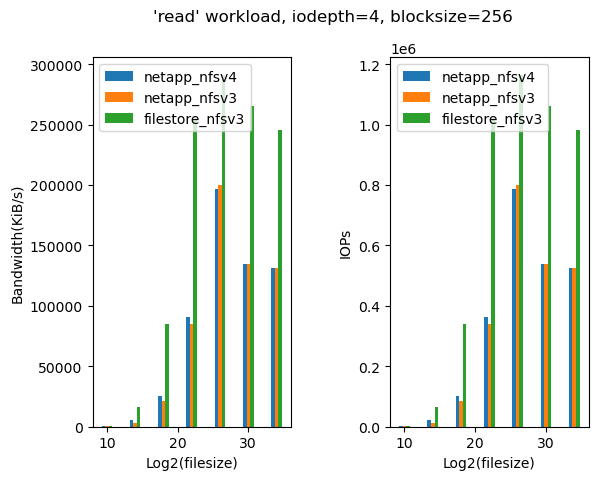

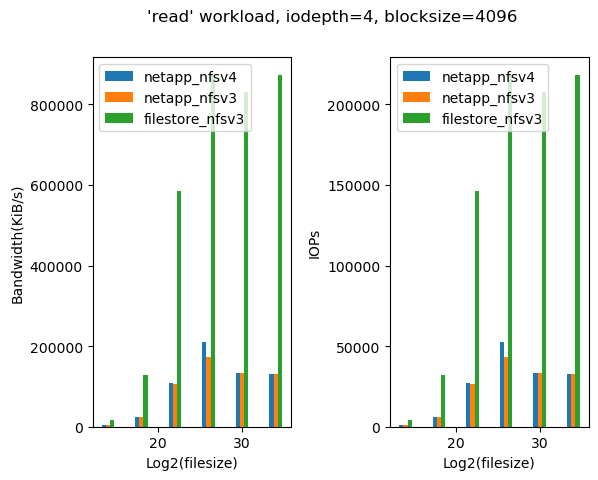

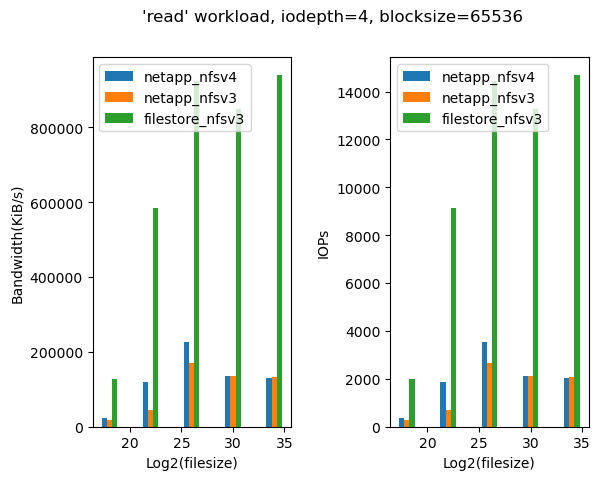

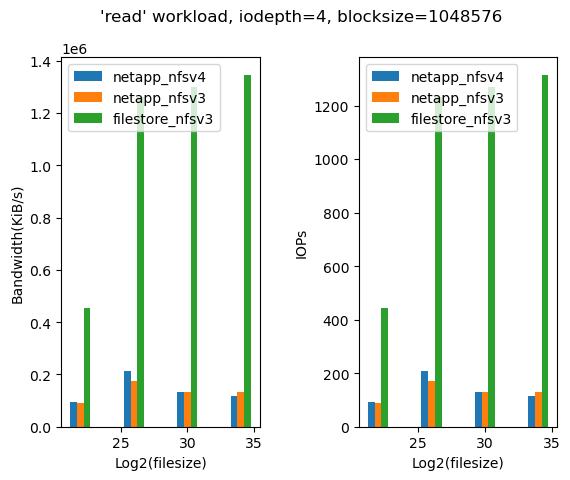

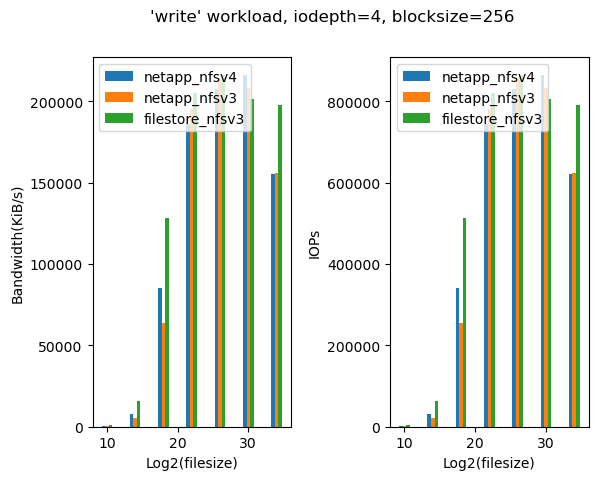

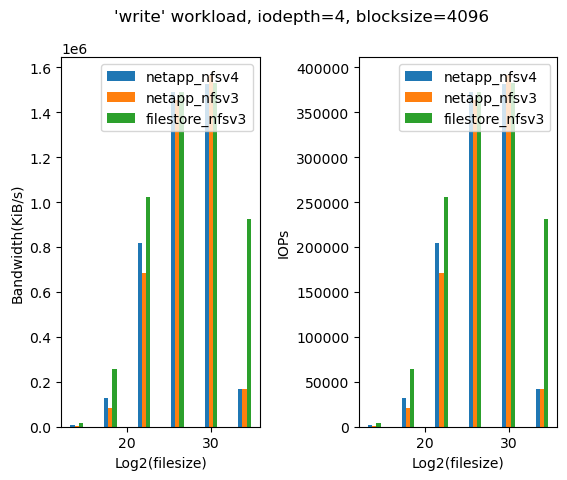

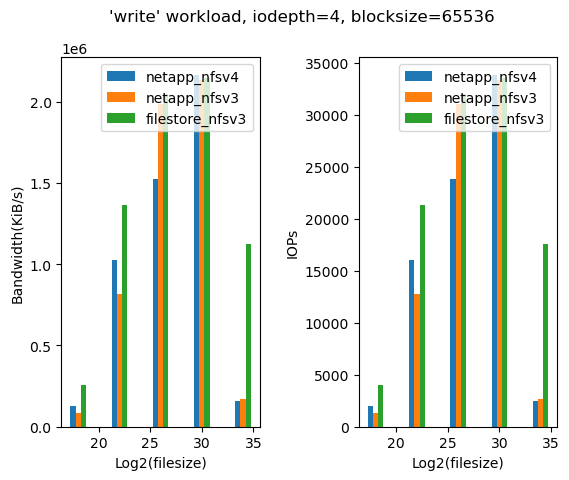

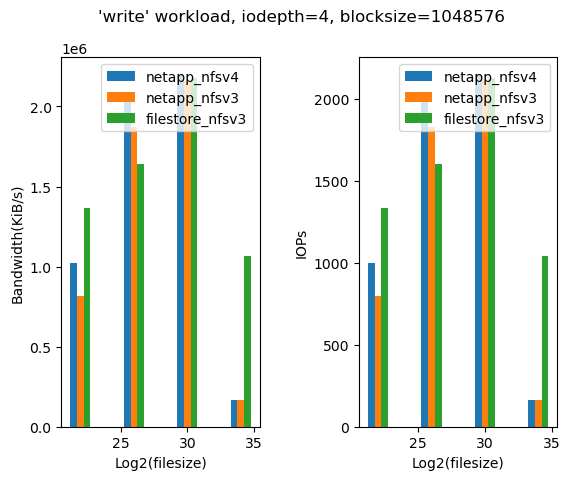

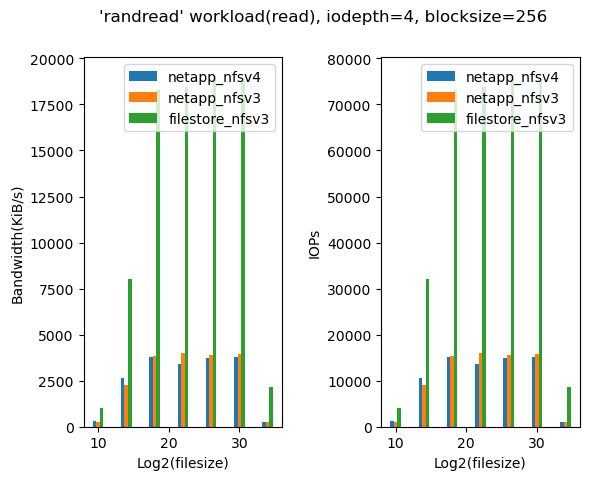

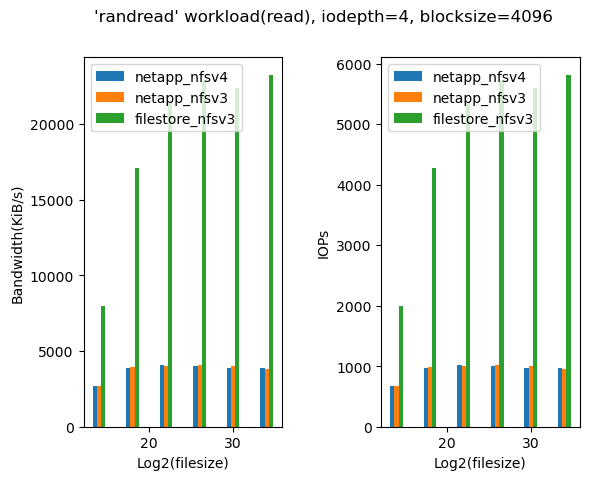

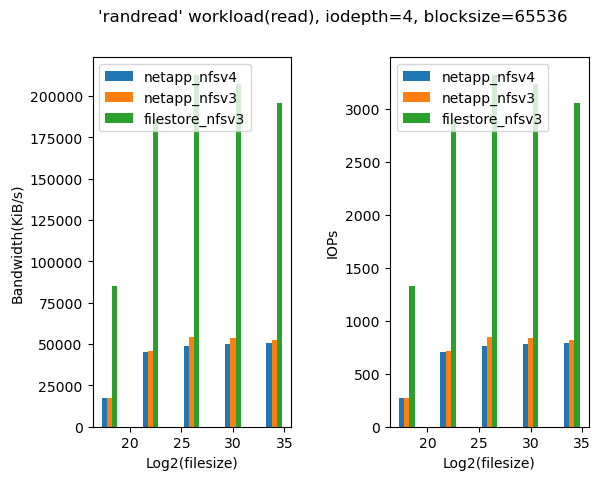

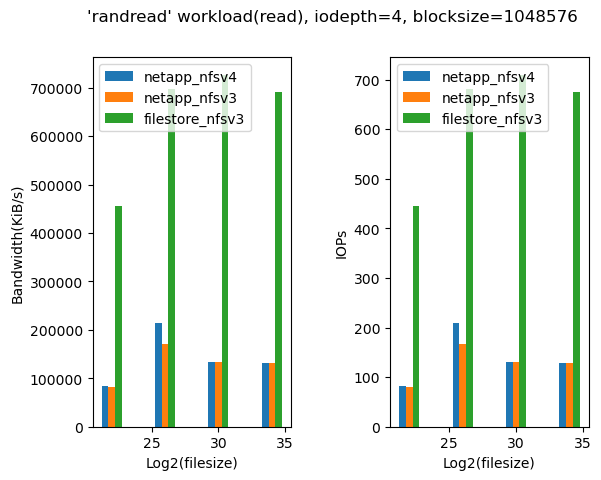

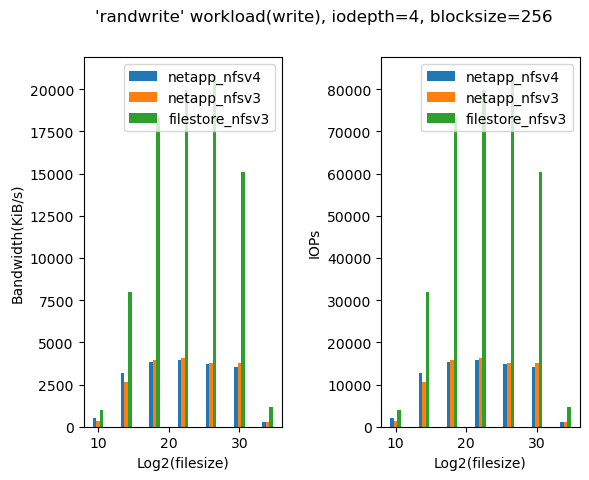

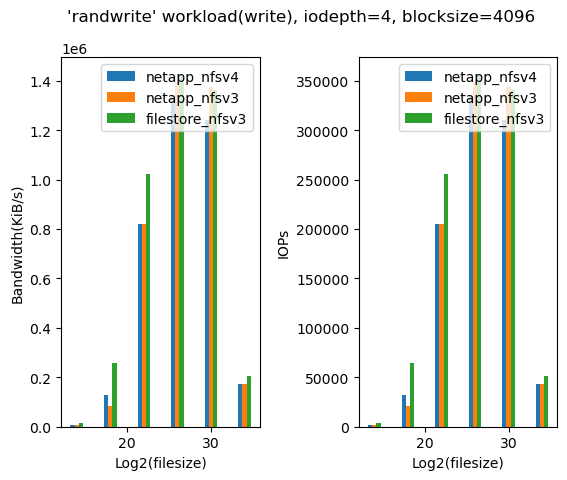

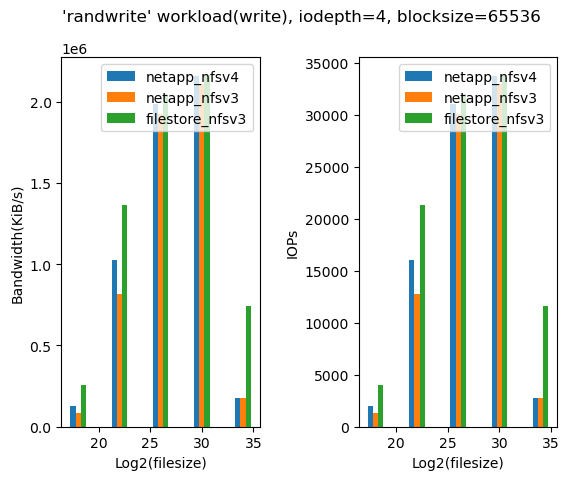

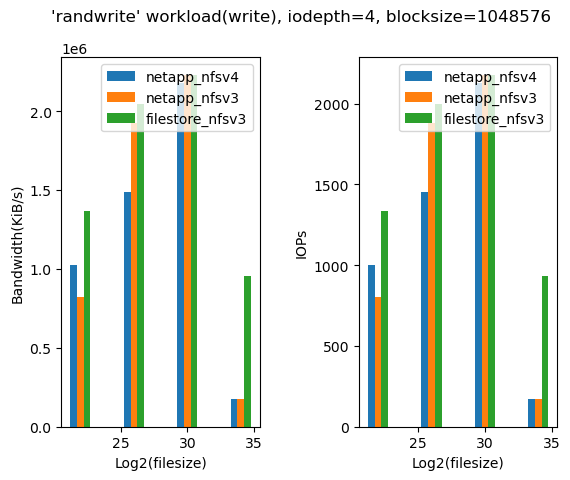

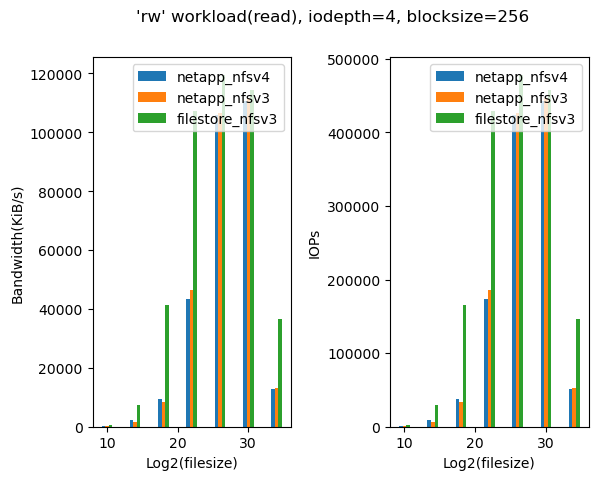

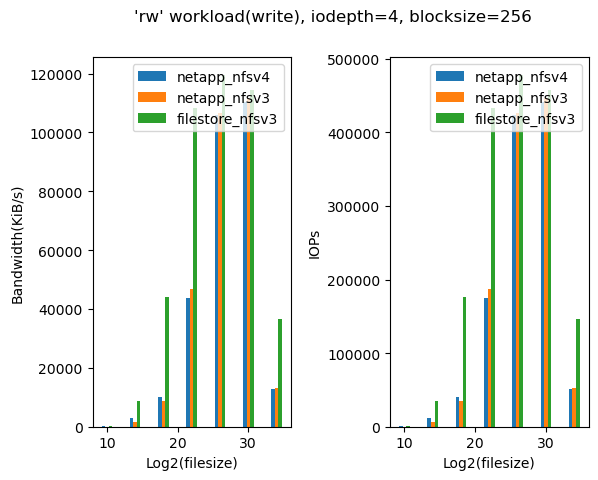

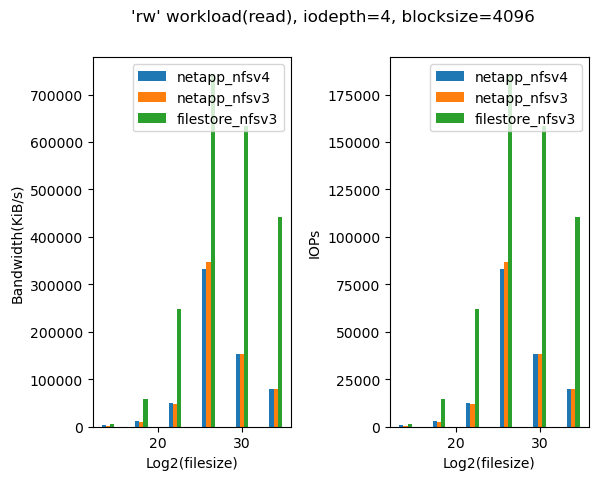

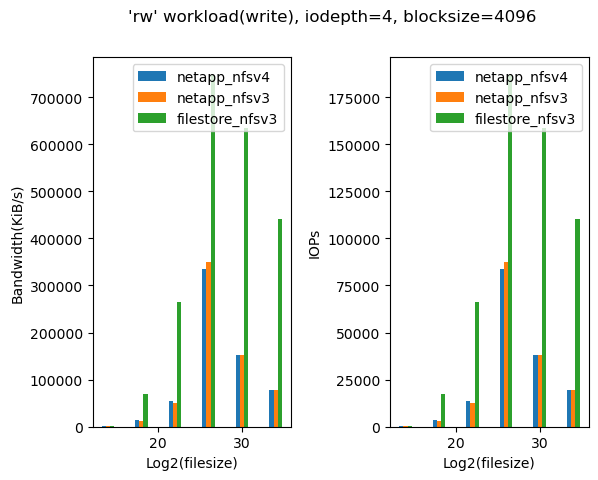

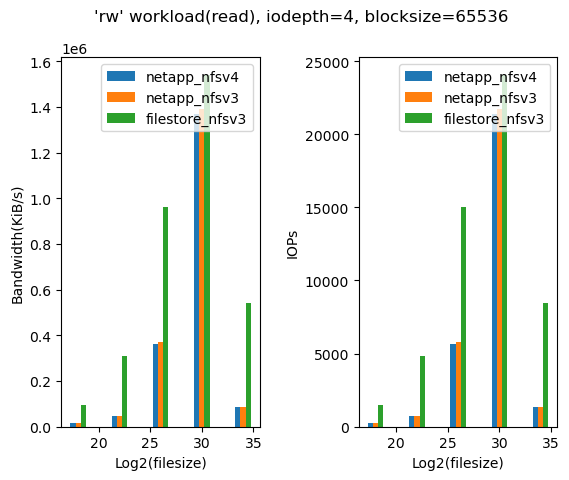

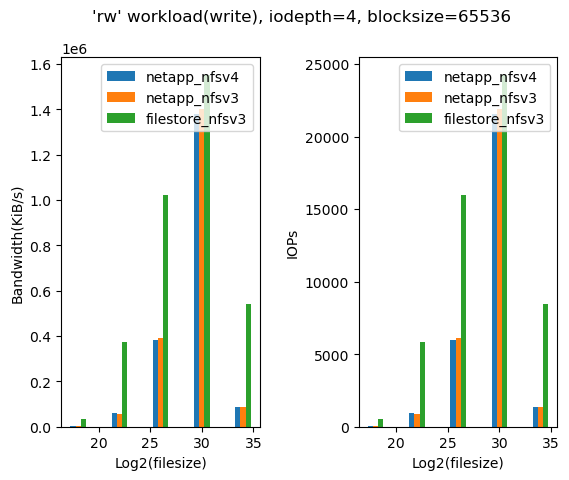

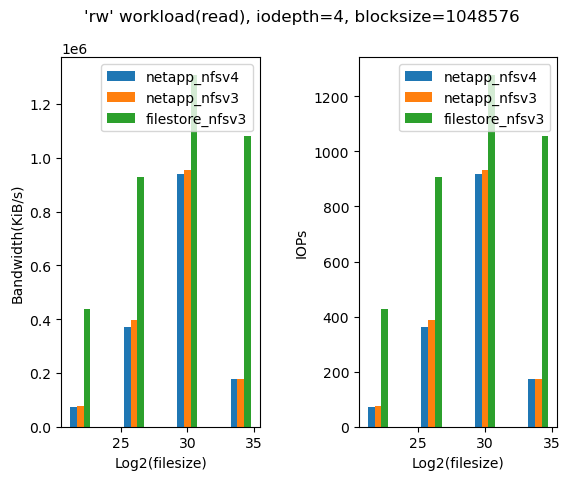

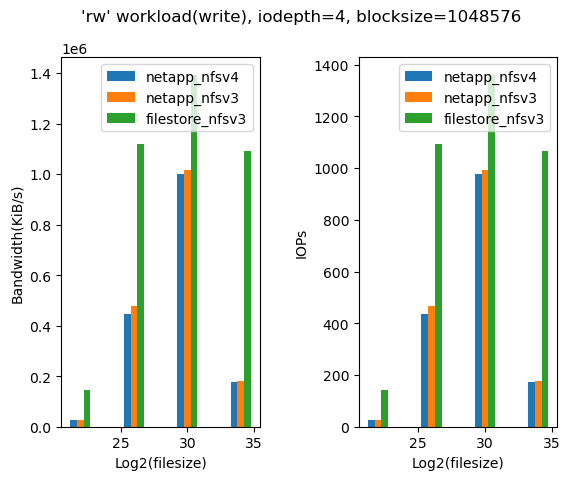

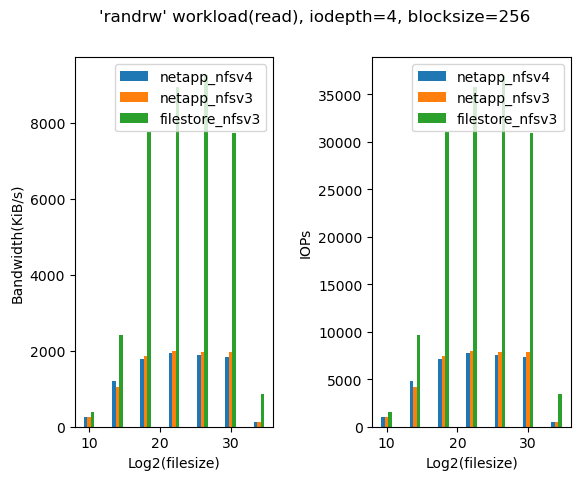

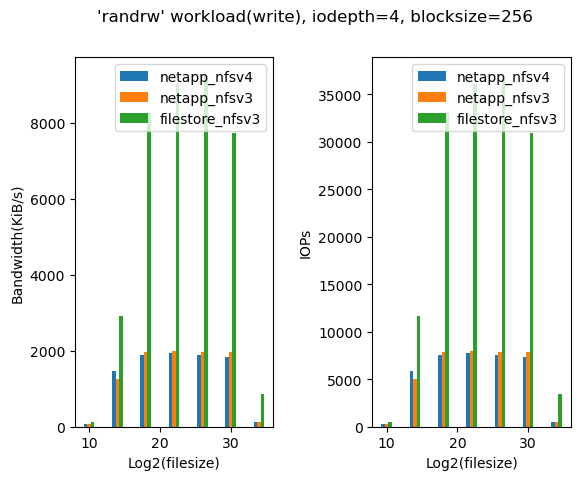

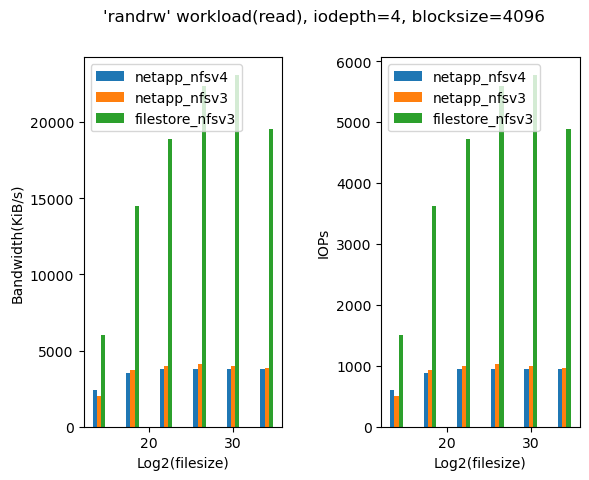

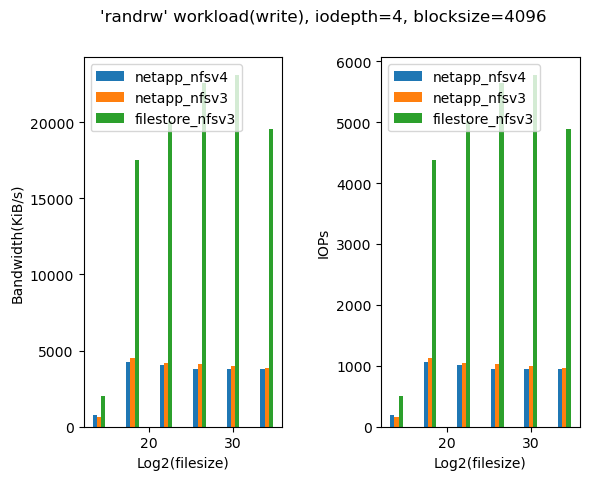

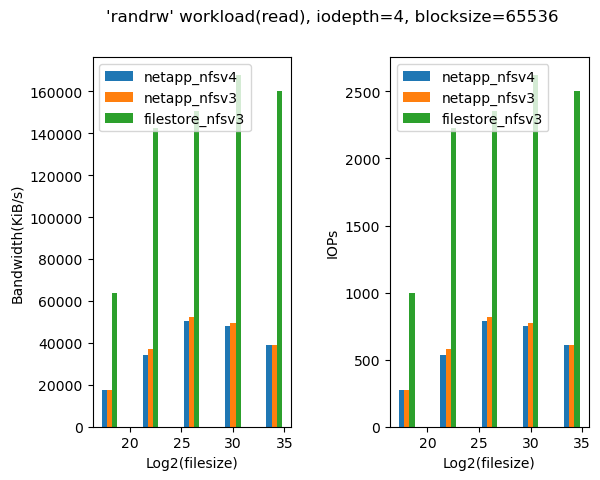

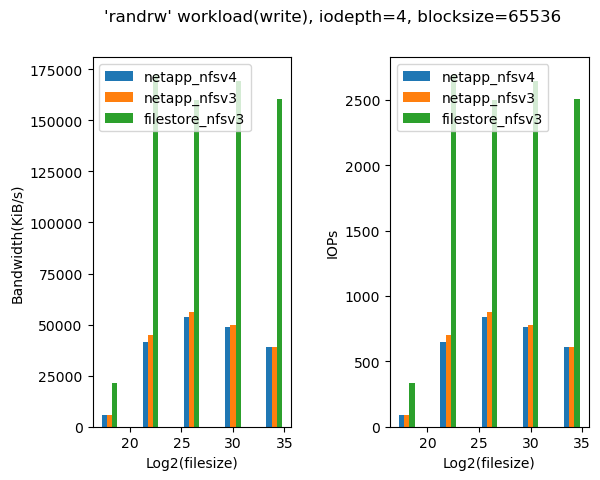

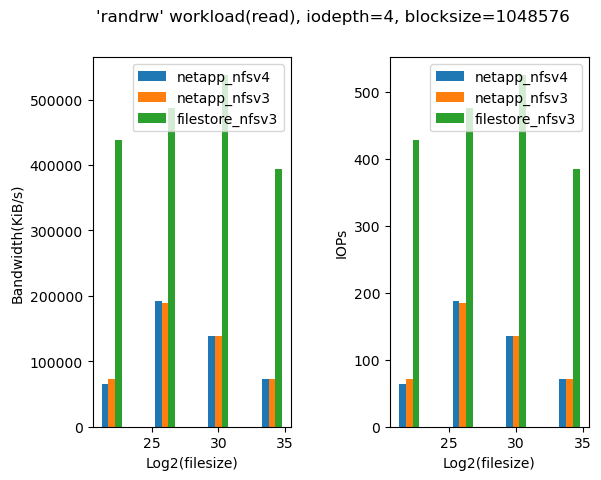

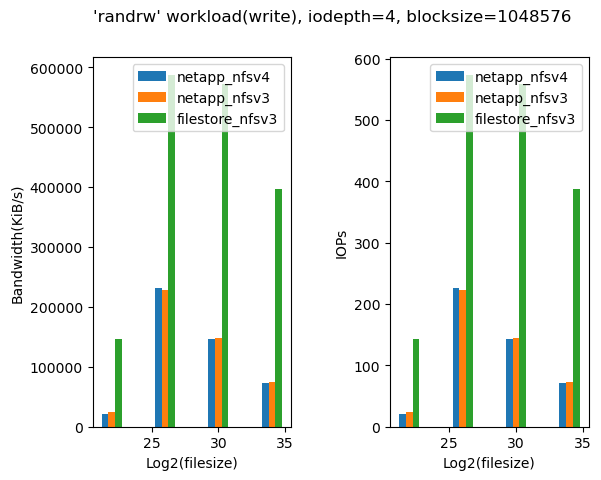

In [11]:
import math

workloads = aggregated["workload"].unique()
iodepths = aggregated["iodepth"].unique()
blocksizes = aggregated["blocksize"].unique()

# Overrides
# workloads = [ "write" ]
# blocksizes = [ 4096 ]
iodepths = [ 4 ]  # Empirically this makes very little difference

for wrk in workloads:
    for blk in blocksizes:
        for iod in iodepths:
            plot_the_category(aggregated, wrk, blk, iod)




